In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [9]:
front_2Dcoord = np.load('front_image.npy', allow_pickle=True)
back_2Dcoord = np.load('back_image.npy', allow_pickle=True)
front_img = cv2.imread('front.png')

(12, 2) (12, 2)


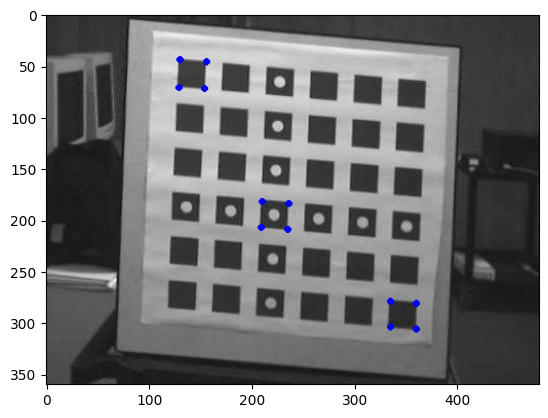

In [10]:
#visualization
print(front_2Dcoord.shape, back_2Dcoord.shape)
from copy import deepcopy
vis_img = deepcopy(front_img)
for i in range(front_2Dcoord.shape[0]):
    cv2.circle(vis_img, (int(front_2Dcoord[i,0]), int(front_2Dcoord[i,1])), 2, (255,0,0), 2)
plt.imshow(vis_img[:,:,::-1])
plt.show()

In [11]:
# ------------TODO----------------
# Compute corresponding 3D coordinate
# ------------TODO----------------
front_3Dcoord = np.zeros((12, 3))
back_3Dcoord = np.zeros((12, 3))

square = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]], dtype=np.float32)*50.0
front_3Dcoord[:4, :] = square
front_3Dcoord[4:8, :] = square + np.array([50*2+30*2, 50*3+30*3, 0], dtype=np.float32)
front_3Dcoord[8:12, :] = square + np.array([50*5+30*5, 50*5+30*5, 0], dtype=np.float32)

back_3Dcoord = front_3Dcoord + np.array([0, 0, 150], dtype=np.float32)

all_2Dcoord = np.concatenate((front_2Dcoord, back_2Dcoord), axis=0)
all_3Dcoord = np.concatenate((front_3Dcoord, back_3Dcoord), axis=0)
print(all_2Dcoord.shape, all_3Dcoord.shape)

(24, 2) (24, 3)


In [12]:
# ------------TODO----------------
# Construct the Equation Pm=0 and solve m
# ------------TODO----------------
# P = np.zeros((48, 12), dtype=np.float32)
# m = np.zeros((12, 1), dtype=np.float32)

# idxs = np.arange(24)
# all_3Dcoord_homo = np.hstack((all_3Dcoord, np.ones((24, 1), dtype=np.float32)))
# P[idxs*2, :4] = all_3Dcoord_homo
# P[idxs*2, 8:] = -all_3Dcoord_homo * np.expand_dims(all_2Dcoord[:, 0], axis=1)
# P[idxs*2+1, 4:8] = all_3Dcoord_homo
# P[idxs*2+1, 8:] = -all_3Dcoord_homo * np.expand_dims(all_2Dcoord[:, 1], axis=1)


P = np.zeros((48, 12))
P_world= np.concatenate((all_3Dcoord, np.ones((24,1))), axis=1)
P_pixel = all_2Dcoord

for i, (p_pixel, p_world) in enumerate(zip(P_pixel, P_world)):
    p1 = np.concatenate((np.eye(2), -p_pixel.reshape((2,1))), axis=1).reshape((6, -1))
    P[2*i: 2*(i + 1)] = (p1 * p_world).reshape(2, 12)
# print(P.shape)

In [13]:
# ------------TODO----------------
# Solve K, and [R T] from m
# ------------TODO----------------

U, S, Vh = np.linalg.svd(P)
m = Vh[-1]
print('m:', m)
m = m.reshape(3,4)
A = m[:,:3]
b = m[:,3]


## intrinsic
rho = 1.0 / np.linalg.norm(A[-1])
cx = (rho**2) * np.dot(A[0], A[2])
cy = (rho**2) * np.dot(A[1], A[2])
print(A[-1])

t1 = np.cross(A[1], A[2])
t2 = np.cross(A[2], A[0])
cos_theta = np.dot(t1, t2) / (np.linalg.norm(t1) * np.linalg.norm(t2))
theta = np.arccos(cos_theta)
alpha = (rho**2) * np.linalg.norm(np.cross(A[0], A[2])) * np.sin(theta)
beta = (rho**2) * np.linalg.norm(np.cross(A[1], A[2])) * np.sin(theta)

K = np.array([
    [alpha, -alpha/(np.tan(theta)+1e-6), cx], 
    [0, beta/(np.sin(theta)+1e-6), cy], 
    [0, 0, 1]], dtype=np.float32)

## Extrinsic
r1 = np.cross(A[1], A[2]) / np.linalg.norm(np.cross(A[1], A[2]))
r3 = A[2] / np.linalg.norm(A[2])
r2 = np.cross(r3, r1)

T = rho * np.dot(np.linalg.inv(K), b)
R = np.vstack((r1, r2, r3))
print(R, T)

m: [ 3.86081985e-03 -1.14839115e-04  8.75272791e-04  9.46068598e-01
  3.42814033e-04  3.92515324e-03 -7.51681648e-04  3.23835234e-01
 -6.97426064e-08  8.23266293e-08 -1.33752673e-08  7.29214554e-03]
[-6.97426064e-08  8.23266293e-08 -1.33752673e-08]
[[ 0.03052016  0.18542639  0.98218408]
 [ 0.76653829  0.62628989 -0.14205641]
 [-0.64147297  0.75721729 -0.12302196]] [383002.97412526 -67358.02646018  67071.11335749]


In [14]:
# save results
save_dict = {'3Dcoord': all_3Dcoord, 'P':P, 'm':m, 'K':K, 'R':R, 'T':T}
np.save('../results/calibr', save_dict)

# The reference answer of T should be [383001.8386981  -67357.81794783  67071.11338303]
# The results are very strange because the data is fake.